In [1]:
from numpy import *
from matplotlib.pyplot import *
import scipy.linalg

In [2]:
data = loadtxt('C:\\Users\\shinj\\Dropbox\\Jacobs Spring 2017\\Project Readings\\Digits\\mfeat-pix.txt')

In [3]:
#Spliting Data into training and Test (1-10)
training = vstack((data[:100],  data[200:300], data[400:500], data[600:700], data[800:900], data[1000:1100], data[1200:1300], data[1400:1500], data[1600:1700], data[1800:1900]))

In [4]:
test = vstack((data[100:200], data[300:400], data[500:600], data[700:800], data[900:1000], data[1100:1200], data[1300:1400], data[1500:1600], data[1700:1800], data[1900:2000]))

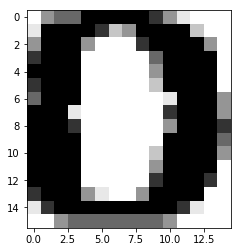

In [5]:
#Shape 
image = data[0].reshape(16,15)
matplotlib.pyplot.imshow(image, cmap = 'Greys')
show()

In [44]:
class echoTrain():
    def __init__(self, training1, training2, training3, training4, test1, inputscale, ridge, sp):
        self.inputscale = inputscale
        self.train1 = (training1/self.inputscale*0.99)+0.01
        self.train2 = (training2/self.inputscale*0.99)+0.01
        self.train3 = (training3/self.inputscale*0.99)+0.01
        self.train4 = (training4/self.inputscale*0.99)+0.01
        self.test = (test1/inputscale*0.99)+0.01
        self.trainLen1 = self.train1.shape[0]
        self.trainLen = self.trainLen1 *4
        self.testLen = self.test.shape[0]
        self.resSize = 300
        self.inSize = 16
        self.outSize = 10
        self.bias = (random.rand(self.resSize, 1)-0.5)/10
        #ridge regression
        self.b = ridge
        self.sp = sp
        
    def reshape(self):
        self.tr1 = zeros((16,0))
        self.tr2 = zeros((16,0))
        self.tr3 = zeros((16,0))
        self.tr4 = zeros((16,0))
        for i in range(self.trainLen1):
            self.tr1 = concatenate((self.tr1, self.train1[i].reshape(16,15)), axis = 1)
            self.tr2 = concatenate((self.tr1, self.train2[i].reshape(16,15)), axis = 1)
            self.tr3 = concatenate((self.tr1, self.train3[i].reshape(16,15)), axis = 1)
            self.tr4 = concatenate((self.tr1, self.train4[i].reshape(16,15)), axis = 1)
        self.te = zeros((16,0))
        for j in range(self.testLen):
            self.te= concatenate((self.te, self.test[j].reshape(16,15)), axis = 1)
            
    def reservoir(self, sp):
        random.seed(2017)
        self.Win = (random.rand(self.resSize, 1+ self.inSize))-0.5
        self.W = random.rand(self.resSize,self.resSize)-0.5
        #Spectral Radius
        self.rhoW = max(abs(linalg.eig(self.W)[0]))
        self.W *= self.sp / self.rhoW
        
    def harvestX(self):
        self.X1 = np.zeros((1+self.inSize + self.resSize,0))
        self.X2 = np.zeros((1+self.inSize + self.resSize,0))
        self.X3 = np.zeros((1+self.inSize + self.resSize,0))
        self.X4 = np.zeros((1+self.inSize + self.resSize,0))      
        for i in range(self.trainLen1):
            self.x1 = np.zeros((self.resSize, 1))
            self.x2 = np.zeros((self.resSize, 1))
            self.x3 = np.zeros((self.resSize, 1))
            self.x4 = np.zeros((self.resSize, 1))            
            for j in range(15*i,15*i+15):
                self.x1 = tanh(dot(self.Win, hstack((1, self.tr1[:,j]))).reshape(self.resSize, 1)+dot(self.W, self.x1)+ self.bias)
                self.x2 = tanh(dot(self.Win, hstack((1, self.tr2[:,j]))).reshape(self.resSize, 1)+dot(self.W, self.x2)+ self.bias)
                self.x3 = tanh(dot(self.Win, hstack((1, self.tr3[:,j]))).reshape(self.resSize, 1)+dot(self.W, self.x3)+ self.bias)
                self.x4 = tanh(dot(self.Win, hstack((1, self.tr4[:,j]))).reshape(self.resSize, 1)+dot(self.W, self.x4)+ self.bias)
            self.X1= concatenate((self.X1, vstack((1, self.tr1[:,j].reshape(16,1), self.x1))), axis = 1)
            self.X2= concatenate((self.X2, vstack((1, self.tr2[:,j].reshape(16,1), self.x2))), axis = 1)
            self.X3= concatenate((self.X3, vstack((1, self.tr3[:,j].reshape(16,1), self.x3))), axis = 1)
            self.X4= concatenate((self.X4, vstack((1, self.tr4[:,j].reshape(16,1), self.x4))), axis = 1)
        self.X = concatenate((self.X1, self.X2, self.X3, self.X4), axis = 1)
            
    def desiredOutput(self):
        self.D = zeros((10, 0))
        for h in range(4):
            self.d = zeros((10, self.trainLen1))
            for i in range(10):
                for j in range(int(i*self.trainLen1/10), int(i*self.trainLen1/10+self.trainLen1/10)):
                    self.d[i,j] = 1
            self.D = concatenate((self.D, self.d), axis = 1)
            
#Calculating Wout
    def wout(self):
        self.Wout = dot(dot(self.D,self.X.T),linalg.inv(dot(self.X, self.X.T)+ dot(self.b, np.identity(1+self.inSize+self.resSize))))

#Calculating Y output from test data
    def output(self):
        self.Y = zeros((10, 0))
        for i in range(self.testLen):
            self.x = zeros((self.resSize, 1))
            for k in range(15*i,15*i+15):
                self.x = tanh(dot(self.Win, hstack((1, self.te[:,k]))).reshape(self.resSize,1)+dot(self.W, self.x) + self.bias)
                self.y = dot(self.Wout, vstack((1, self.te[:,k].reshape(16,1),self.x)))
            self.Y = concatenate((self.Y, self.y), axis = 1)
        

#D(Desired Output) for error calculation
    def desiredtestOutput(self):        
        self.Dt = zeros((10, self.testLen))
        for i in range(10):
            for j in range(int(i*self.testLen/10), int(i*self.testLen/10+self.testLen/10)):
                self.Dt[i,j] = 1
                
#Score Evaluation (Correct Labels / Total Labels, Error: Incorrect Labels / Total Labels)               
    def score(self):
        self.scorecard = []
        self.score = 0
        for i in range(self.testLen):
            if argmax(self.Y[0:10, i]) == argmax(self.Dt[0:10, i]):
                self.scorecard.append(1)
                self.score += 1
            else:
                self.scorecard.append(0)
    def printscore(self):
        self.er = (self.testLen-self.score)/self.testLen
        print("ResSize: ", self.resSize, "Input Scaling: ", self.inputscale, "Ridge Regression: ", self.b, "Spectral Radius: ", self.sp)
        print("Accuracy: ", self.score/self.testLen) 
        print("Error Rate: ",  (self.testLen-self.score)/self.testLen)

    def scoredetail(self):
        print("Incorrect Answers", i)
    def xplot(self):
        self.A = np.zeros((1+self.inSize+self.resSize, 0))
        self.a = np.zeros((self.resSize, 1))
        for j in range(15):
            self.a = tanh(dot(self.Win, hstack((1, self.tr2[:,j]))).reshape(self.resSize, 1)+dot(self.W, self.a)+ self.bias)
            self.A= concatenate((self.A, vstack((1, self.tr2[:,j].reshape(16,1), self.a))), axis = 1)
        figure(2).clear()
        plot(self.A.T)
        title('X')
        show()

In [7]:
class run():
    def __init__(self, training1, training2, training3, training4, training5, resSize, ridge, sp):
        ech = echoTrain(training1, training2, training3, training4, training5, resSize, ridge, sp)
        ech.reshape()
        ech.reservoir(sp)
        ech.harvestX()
        ech.desiredOutput()
        ech.wout()
        ech.output()
        ech.desiredtestOutput()
        ech.score()
        ech.printscore()
        self.er = (ech.testLen-ech.score) / ech.testLen

In [8]:
class plotrun():
    def __init__(self, training1, training2, training3, training4, training5, resSize, ridge, sp):
        ech = echoTrain(training1, training2, training3, training4, training5, resSize, ridge, sp)
        ech.reshape()
        ech.reservoir(sp)
        ech.xplot()

In [9]:
#Data Splitting

In [10]:
training1 = vstack((training[0:20], training[100:120], training[200:220],training[300:320], training[400:420], training[500:520], training[600:620],training[700:720],training[800:820],training[900:920])) 

In [11]:
training2 = vstack((training[20:40], training[120:140], training[220:240],training[320:340], training[420:440], training[520:540], training[620:640],training[720:740],training[820:840],training[920:940])) 

In [12]:
training3 = vstack((training[40:60], training[140:160], training[240:260],training[340:360], training[440:460], training[540:560], training[640:660],training[740:760],training[840:860],training[940:960])) 

In [13]:
training4 = vstack((training[60:80], training[160:180], training[260:280],training[360:380], training[460:480], training[560:580], training[660:680],training[760:780],training[860:880],training[960:980])) 

In [14]:
training5 = vstack((training[80:100], training[180:200], training[280:300],training[380:400], training[480:500], training[580:600], training[680:700],training[780:800],training[880:900],training[980:1000])) 

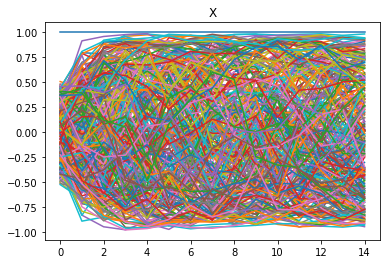

In [15]:
a = plotrun(training1, training2, training3, training4, training5, 255, 1e-1, 1.38)

In [16]:
#Run 5 folds Cross Validation - Scaling: 255, Ridge Regression: 1e-1, Spectral Radius: 1.38
b = run(training1, training2, training3, training4, training5, 255, 1e-1, 1.38)
b = run(training1, training2, training3, training5, training4, 255, 1e-1, 1.38)
b = run(training1, training2, training4, training5, training3, 255, 1e-1, 1.38)
b = run(training1, training3, training4, training5, training2, 255, 1e-1, 1.38)
b = run(training2, training3, training4, training5, training1, 255, 1e-1, 1.38)

In [ ]:
#Run 5 folds Cross Validation and test output - Size of Reservoir: 255, Ridge Regression: 1e-1, Spectral Radius: 1.38
b = run(training1, training2, training3, training4, test, 255, 1e-1, 1.38)
b = run(training1, training2, training3, training5, test, 255, 1e-1, 1.38)
b = run(training1, training2, training4, training5, test, 255, 1e-1, 1.38)
b = run(training2, training3, training4, training5, test, 255, 1e-1, 1.38)
b = run(training1, training3, training4, training5, test, 255, 1e-1, 1.38)

In [46]:
#Try Different Number of Input Scaling , Reservoir Size: 300, Ridge Regression: 0.1, Spectral Radius: 1.38
ridgeregression = []
spectralradius = []
error = []
for i in range(1, 200, 10):
    for j in range(10, 100, 5):
        Error_inputscale = 0
        b = run(training1, training2, training3, training4, training5, 155, i*0.01, 1+j*0.01)
        Error_inputscale += b.er
        b = run(training1, training2, training3, training5, training4, 155, i*0.01, 1+j*0.01)
        Error_inputscale += b.er
        b = run(training1, training2, training4, training5, training3, 155, i*0.01, 1+j*0.01)
        Error_inputscale += b.er
        b = run(training1, training3, training4, training5, training2, 155, i*0.01, 1+j*0.01)
        Error_inputscale += b.er
        b = run(training2, training3, training4, training5, training1, 155, i*0.01, 1+j*0.01)
        Error_inputscale += b.er
        error_av = Error_inputscale/5
        error.append(error_av)
        print("RR: ", i*0.01, "SR: ", 1+j*0.01, "Er: ", error_av)
        ridgeregression.append(i*0.01)
        spectralradius.append(1+j*0.01)

RR:  0.01 SR:  1.1 Er:  0.21400000000000002
RR:  0.01 SR:  1.15 Er:  0.197
RR:  0.01 SR:  1.2 Er:  0.189
RR:  0.01 SR:  1.25 Er:  0.191
RR:  0.01 SR:  1.3 Er:  0.185
RR:  0.01 SR:  1.35 Er:  0.17099999999999999
RR:  0.01 SR:  1.4 Er:  0.16499999999999998
RR:  0.01 SR:  1.45 Er:  0.15100000000000002
RR:  0.01 SR:  1.5 Er:  0.14400000000000002
RR:  0.01 SR:  1.55 Er:  0.14200000000000002
RR:  0.01 SR:  1.6 Er:  0.134
RR:  0.01 SR:  1.65 Er:  0.137
RR:  0.01 SR:  1.7000000000000002 Er:  0.14500000000000002
RR:  0.01 SR:  1.75 Er:  0.14200000000000002
RR:  0.01 SR:  1.8 Er:  0.15499999999999997
RR:  0.01 SR:  1.85 Er:  0.15699999999999997
RR:  0.01 SR:  1.9 Er:  0.18200000000000002
RR:  0.01 SR:  1.9500000000000002 Er:  0.19000000000000003
RR:  0.11 SR:  1.1 Er:  0.215
RR:  0.11 SR:  1.15 Er:  0.193
RR:  0.11 SR:  1.2 Er:  0.18400000000000002
RR:  0.11 SR:  1.25 Er:  0.17200000000000001
RR:  0.11 SR:  1.3 Er:  0.158
RR:  0.11 SR:  1.35 Er:  0.155
RR:  0.11 SR:  1.4 Er:  0.155
RR:  0.11 SR:

In [21]:
#Try Different Number of parameter Iterization , Reservoir Size: 70 
ridgeregression70 = []
spectralradius70 = []
error70 = []
for i in range(1, 200, 10):
    for j in range(10, 100, 5):
        Error_inputscale = 0
        b = run(training1, training2, training3, training4, training5, 70, i*0.01, 1+j*0.01)
        Error_inputscale += b.er
        b = run(training1, training2, training3, training5, training4, 70, i*0.01, 1+j*0.01)
        Error_inputscale += b.er
        b = run(training1, training2, training4, training5, training3, 70, i*0.01, 1+j*0.01)
        Error_inputscale += b.er
        b = run(training1, training3, training4, training5, training2, 70, i*0.01, 1+j*0.01)
        Error_inputscale += b.er
        b = run(training2, training3, training4, training5, training1, 70, i*0.01, 1+j*0.01)
        error_av = Error_inputscale/5
        error70.append(error_av)
        print("RR: ", i*0.01, "SR: ", 1+j*0.01, "Er: ", error_av)
        ridgeregression70.append(i*0.01)
        spectralradius70.append(1+j*0.01)

RR:  0.01 SR:  1.1 Er:  0.176
RR:  0.01 SR:  1.15 Er:  0.16299999999999998
RR:  0.01 SR:  1.2 Er:  0.15299999999999997
RR:  0.01 SR:  1.25 Er:  0.14500000000000002
RR:  0.01 SR:  1.3 Er:  0.139
RR:  0.01 SR:  1.35 Er:  0.138
RR:  0.01 SR:  1.4 Er:  0.14100000000000001
RR:  0.01 SR:  1.45 Er:  0.132
RR:  0.01 SR:  1.5 Er:  0.14
RR:  0.01 SR:  1.55 Er:  0.148
RR:  0.01 SR:  1.6 Er:  0.156
RR:  0.01 SR:  1.65 Er:  0.16
RR:  0.01 SR:  1.7000000000000002 Er:  0.14100000000000001
RR:  0.01 SR:  1.75 Er:  0.148
RR:  0.01 SR:  1.8 Er:  0.175
RR:  0.01 SR:  1.85 Er:  0.219
RR:  0.01 SR:  1.9 Er:  0.22600000000000003
RR:  0.01 SR:  1.9500000000000002 Er:  0.23500000000000001
RR:  0.11 SR:  1.1 Er:  0.172
RR:  0.11 SR:  1.15 Er:  0.16
RR:  0.11 SR:  1.2 Er:  0.15100000000000002
RR:  0.11 SR:  1.25 Er:  0.141
RR:  0.11 SR:  1.3 Er:  0.122
RR:  0.11 SR:  1.35 Er:  0.121
RR:  0.11 SR:  1.4 Er:  0.11399999999999999
RR:  0.11 SR:  1.45 Er:  0.11499999999999999
RR:  0.11 SR:  1.5 Er:  0.108000000000000

In [30]:
#Try Different Number of parameter Iterization , Reservoir Size: 255, 
ridgeregression255 = []
spectralradius255 = []
error255 = []
for i in range(1, 200, 10):
    for j in range(10, 100, 5):
        Error_inputscale = 0
        b = run(training1, training2, training3, training4, training5, 255, i*0.01, 1+j*0.01)
        Error_inputscale += b.er
        b = run(training1, training2, training3, training5, training4, 255, i*0.01, 1+j*0.01)
        Error_inputscale += b.er
        b = run(training1, training2, training4, training5, training3, 255, i*0.01, 1+j*0.01)
        Error_inputscale += b.er
        b = run(training1, training3, training4, training5, training2, 255, i*0.01, 1+j*0.01)
        Error_inputscale += b.er
        b = run(training2, training3, training4, training5, training1, 255, i*0.01, 1+j*0.01)
        error_av = Error_inputscale/5
        error255.append(error_av)
        print("RR: ", i*0.01, "SR: ", 1+j*0.01, "Er: ", error_av)
        ridgeregression255.append(i*0.01)
        spectralradius255.append(1+j*0.01)

RR:  0.01 SR:  1.1 Er:  0.176
RR:  0.01 SR:  1.15 Er:  0.15499999999999997
RR:  0.01 SR:  1.2 Er:  0.15500000000000003
RR:  0.01 SR:  1.25 Er:  0.148
RR:  0.01 SR:  1.3 Er:  0.14300000000000002
RR:  0.01 SR:  1.35 Er:  0.139
RR:  0.01 SR:  1.4 Er:  0.136
RR:  0.01 SR:  1.45 Er:  0.13199999999999998
RR:  0.01 SR:  1.5 Er:  0.128
RR:  0.01 SR:  1.55 Er:  0.118
RR:  0.01 SR:  1.6 Er:  0.11000000000000001
RR:  0.01 SR:  1.65 Er:  0.11100000000000002
RR:  0.01 SR:  1.7000000000000002 Er:  0.10700000000000001
RR:  0.01 SR:  1.75 Er:  0.10600000000000001
RR:  0.01 SR:  1.8 Er:  0.10400000000000001
RR:  0.01 SR:  1.85 Er:  0.10700000000000001
RR:  0.01 SR:  1.9 Er:  0.11099999999999999
RR:  0.01 SR:  1.9500000000000002 Er:  0.11699999999999999
RR:  0.11 SR:  1.1 Er:  0.178
RR:  0.11 SR:  1.15 Er:  0.16
RR:  0.11 SR:  1.2 Er:  0.15100000000000002
RR:  0.11 SR:  1.25 Er:  0.138
RR:  0.11 SR:  1.3 Er:  0.129
RR:  0.11 SR:  1.35 Er:  0.122
RR:  0.11 SR:  1.4 Er:  0.118
RR:  0.11 SR:  1.45 Er:  0.1